In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch import cuda
from tqdm import tqdm
from transformers import BertConfig
from transformers import BertModel
import json
import matplotlib.pyplot as plt
import os
import pickle
from tqdm import tqdm


from transformers import AutoTokenizer, T5ForConditionalGeneration

PRETRAINED_MODEL_NAME = "t5-small"
FINETUNED_MODEL_NAME = "T5_Model/t5_20_epochs"
FINETUNED_MODEL_NAME = "T5_Model/t5_9_epochs"
# FINETUNED_MODEL_NAME = "T5_Model/checkpoint-177280"

EPOCHS = 10
TRAIN_BATCH_SIZE = 256
VALID_BATCH_SIZE = 256
SEQ_LEN=17

model = T5ForConditionalGeneration.from_pretrained(FINETUNED_MODEL_NAME)
tokenizer = AutoTokenizer.from_pretrained(
    PRETRAINED_MODEL_NAME,
    padding_side="left"
)
tokenizer_r = AutoTokenizer.from_pretrained(
    PRETRAINED_MODEL_NAME,
    padding_side="right"
)

device = 'cuda' if cuda.is_available() else 'cpu'

/media/HDD/bportelli/env/lib/python3.8/site-packages/transformers/models/t5/tokenization_t5_fast.py:156: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-small automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(


In [2]:
from torch.utils.data import TensorDataset, DataLoader

def batchify(l, batch_size):
    i = 0
    while i < len(l):
        i += batch_size
        yield l[i-batch_size:i]

def to_tensor_dataset(data, tokenizer, kind):
    
    input_ids = []
    labels = []
    
    outputs = tokenizer_r(["Helyx", "Strand", "Coil"], padding="longest")
    outputs = {i:v for i,v in enumerate(outputs.input_ids)}
    
    labels = data.target.apply(lambda x: outputs[x])#[outputs[row.target] for _,row in tqdm(data.iterrows(), total=len(data))]
    labels = torch.tensor(labels)
    
    print(labels.shape)
        
    batch_size = 200
    
    for sentences in tqdm(batchify(data.Seq, batch_size), total=len(data)//batch_size):
        
        tok_out = tokenizer(sentences.tolist(), add_special_tokens=False, padding="longest")
        tok_out = [
            [x for x in seq if (x != 3) and (x != 0)]
            for seq in tok_out.input_ids
        ]
        tok_out = [
            seq + [tokenizer.pad_token_id]*(SEQ_LEN-len(seq))
            for seq in tok_out
        ]
        
        input_ids += tok_out
    
    input_ids = torch.tensor(input_ids)
    
    print(input_ids.shape)
    
    return TensorDataset(input_ids, labels)

import pickle
import os

if not os.path.exists("T5_Model/train_dataset.pkl"):

    train_dataset = to_tensor_dataset(df, tokenizer, "TRAIN")
    test_dataset = to_tensor_dataset(df_, tokenizer, "TEST")

    with open("train_dataset.pkl", "wb") as f:
        pickle.dump(train_dataset, f)
    with open("test_dataset.pkl", "wb") as f:
        pickle.dump(test_dataset, f)
        

        
with open("T5_Model/train_dataset.pkl", "rb") as f:
    train_dataset = pickle.load(f)
train_dataloader = DataLoader(train_dataset, batch_size=300)
with open("T5_Model/test_dataset.pkl", "rb") as f:
    test_dataset = pickle.load(f)
test_dataloader = DataLoader(test_dataset, batch_size=300)


from sklearn.metrics import classification_report

for dl, kind in [
    # (train_dataloader, "train"),
    (test_dataloader, "test")
]:
    
    if not os.path.exists(FINETUNED_MODEL_NAME+f"/pred_summary_{kind}.pickle"):

        model.eval()
        model.to(device)

        all_pred = []
        all_gold = []

        for input_ids, labels in tqdm(dl):

            with torch.no_grad():
                out = model.generate(
                    inputs=input_ids.to(device),
                    max_new_tokens=1
                )
            pred = tokenizer.batch_decode(out[:,-1])
            gold = tokenizer.batch_decode(labels[:,0])

            all_pred += pred
            all_gold += gold

        print("gold labels |", set(all_gold))
        print("pred labels |", set(all_pred))

        pred_dict = {
            "He": 0,
            "Strand": 1 if FINETUNED_MODEL_NAME == "T5_Model/t5_20_epochs" else 2, # actually coil
            "Co": 2 if FINETUNED_MODEL_NAME == "T5_Model/t5_20_epochs" else 1, # actually strand
        }
        all_pred = [pred_dict[x] for x in all_pred]
        all_gold = [pred_dict[x] for x in all_gold]

        pred_summary_test = pd.DataFrame({"real": all_gold, "pred": all_pred})
        pred_summary_test.to_pickle(FINETUNED_MODEL_NAME+f"/pred_summary_{kind}.pickle")
        
    pred_summary_test = pd.read_pickle(FINETUNED_MODEL_NAME+f"/pred_summary_{kind}.pickle")
        
    print(classification_report(pred_summary_test.real, pred_summary_test.pred))


              precision    recall  f1-score   support

           0       0.74      0.76      0.75    202335
           1       0.67      0.68      0.67    183014
           2       0.61      0.55      0.58    105263

    accuracy                           0.69    490612
   macro avg       0.67      0.66      0.67    490612
weighted avg       0.68      0.69      0.68    490612



In [3]:
# pred_summary_test = pd.read_pickle(FINETUNED_MODEL_NAME+f"/pred_summary_train.pickle")
# print(round((pred_summary_test.real==pred_summary_test.pred).sum()/len(pred_summary_test), 4))
pred_summary_test = pd.read_pickle(FINETUNED_MODEL_NAME+f"/pred_summary_test.pickle")
print(round((pred_summary_test.real==pred_summary_test.pred).sum()/len(pred_summary_test), 4))

0.6857


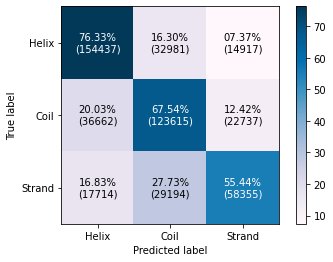

In [4]:
import pandas as pd
from sklearn.metrics import confusion_matrix
pred_summary_test = pd.read_pickle(FINETUNED_MODEL_NAME+f"/pred_summary_test.pickle")

df = pred_summary_test
M=confusion_matrix(df.real.tolist(), df.pred.tolist())
M_norm = (M.T/M.sum(1)).T*100
heatmap = plt.imshow(M_norm, cmap="PuBu")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.xticks([0,1,2], ["Helix","Coil","Strand"])
plt.yticks([0,1,2], ["Helix","Coil","Strand"])
for x in range(3):
    for y in range(3):
        
        perc = str(round(M_norm[y,x]/100,4)).ljust(6,'0')[2:]
        perc = perc[:2]+"."+perc[2:]
        
        plt.text(
            x,y,
            f"{perc}%\n({M[y,x]})",
            ha="center",
            va="center",
            c="w" if M_norm[y,x]>50 else "k"
        )
        
plt.colorbar(heatmap)
plt.savefig(f"plots/T5_Model.confmat_test.pdf", dpi=300)
plt.show()

In [5]:
import pandas as pd
from tqdm import tqdm
import torch
import numpy as np
from matplotlib import pyplot as plt
import json


def batchify(l, batch_size):
    i = 0
    while i < len(l):
        i += batch_size
        yield l[i-batch_size:i]


test_data = pd.read_csv("Bert_Model/new_17resid_test_data.txt", encoding='unicode_escape', names=['Seq'])
test_target = pd.read_csv("Bert_Model/Ntest_3states_target.txt", encoding='unicode_escape', names=['target'])


# from transformers import AutoTokenizer, T5ForConditionalGeneration
# model = T5ForConditionalGeneration.from_pretrained("t5-small")
# tokenizer = AutoTokenizer.from_pretrained("t5-small")


df_ = pd.concat([test_data, test_target], axis=1)#.head(5000)
df_["x"] = df_.Seq.apply(lambda val: " ".join([x.replace("B", tokenizer.pad_token) for x in val]))
df_

,Seq,target,x
0,BBBBBBBBAAADGDDSL,1,<pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad...
1,BBBBBBBAAADGDDSLY,1,<pad> <pad> <pad> <pad> <pad> <pad> <pad> A A ...
2,BBBBBBAAADGDDSLYP,1,<pad> <pad> <pad> <pad> <pad> <pad> A A A D G ...
3,BBBBBAAADGDDSLYPI,1,<pad> <pad> <pad> <pad> <pad> A A A D G D D S ...
4,BBBBAAADGDDSLYPIA,1,<pad> <pad> <pad> <pad> A A A D G D D S L Y P I A
...,...,...,...
490607,FKEELEKKGLGGKBBBB,1,F K E E L E K K G L G G K <pad> <pad> <pad> <pad>
490608,KEELEKKGLGGKBBBBB,1,K E E L E K K G L G G K <pad> <pad> <pad> <pad...
490609,EELEKKGLGGKBBBBBB,1,E E L E K K G L G G K <pad> <pad> <pad> <pad> ...
490610,ELEKKGLGGKBBBBBBB,1,E L E K K G L G G K <pad> <pad> <pad> <pad> <p...


In [6]:
import torch.nn as nn
from captum.attr import DeepLift

device = "cuda"


class BertModelWrapper(nn.Module):

    def __init__(self, model):
        super(BertModelWrapper, self).__init__()
        self.model = model

    def forward(self, embeddings, attention_mask=None, head_mask=None, position=0):
        model_class = type(self.model)
        outputs = self.model.generate(
            inputs_embeds = embeddings,
            return_dict_in_generate=True,
            output_scores=True,
            max_new_tokens=1,
            # attention_mask = attention_mask, 
            # head_mask = head_mask,
        )
        outputs = outputs.scores
      
        return outputs[0]  # .argmax(1)

def interpret_sentence(model_wrapper, sentence, label=1, position=0, plot=True, max_len=None):
    model_wrapper.eval()
    model_wrapper.zero_grad()
    max_len = model_wrapper.model.config.max_position_embeddings if max_len is None else max_len

    tok_out = tokenizer(sentence, add_special_tokens=False, padding="longest")#"max_length", max_length=max_len)
    
    tok_out = [
        [x for x in seq if (x != 3) and (x != 0)]
        for seq in tok_out.input_ids
    ]
    tok_out = [
        seq + [tokenizer.pad_token_id]*(max_len-len(seq))
        for seq in tok_out
    ]
    
    for x,s in zip(tok_out, sentence):
        if len(x)!=17:
            print(len(x), x, s)
    
    input_ids = torch.tensor(tok_out)
    baseline_input_ids = torch.ones_like(input_ids) * tokenizer.pad_token_id

    attention_mask = torch.ones_like(input_ids)
    
    input_ids=input_ids.to(device)
    baseline_input_ids=baseline_input_ids.to(device)
    
    input_embedding = model_wrapper.model.shared(input_ids)
    
    baseline_input_embedding = model_wrapper.model.shared(baseline_input_ids)

    # predict
    pred = model_wrapper(input_embedding)  # .item()
    
    # print(pred)
    
    
    # print(input_embedding)
    # print(baseline_input_embedding)
    
    
    # print(model_wrapper(baseline_input_embedding))
    
    # pred_ind = pred.argmax().item()  # round(pred)
    
    # compute attributions and approximation delta using integrated gradients
    # if CAPTUM_ALG == IntegratedGradients:
    #     attributions_ig, delta = ig.attribute(input_embedding, n_steps=2, target=label)
    # elif CAPTUM_ALG == Saliency or CAPTUM_ALG == FeatureAblation or CAPTUM_ALG == DeepLift:
    #     attributions_ig = ig.attribute(
    #         input_embedding,
    #         target=label,
    #         baselines=baseline_input_embedding,
    #         additional_forward_args=(None, None, position)
    #     )
    attributions_ig = dl.attribute(
            input_embedding,
            target=label,
            baselines=baseline_input_embedding,
            additional_forward_args=(None, None, position)
    )

    tokens = tokenizer.convert_ids_to_tokens(input_ids[0].detach().cpu().numpy().tolist())

    attributions = attributions_ig.sum(dim=-1).squeeze(0)
    attributions = attributions / torch.norm(attributions, dim=-1).unsqueeze(-1)
    if len(attributions.shape) == 1:
        attributions = attributions.unsqueeze(0)
    attributions = attributions.detach().cpu().numpy()
    # attributions = np.mean(attributions, axis=0)
    attributions = np.mean(np.absolute(attributions), axis=0)

    if plot:
        visualize_importances(tokens, attributions, log=False)
    # return tokens, attributions, pred, pred_ind, label
    return attributions

def visualize_importances(feature_names, importances, title="Average Feature Importances", plot=True,
                          axis_title="Features", log=False):
    print(title)
    x_pos = [x for x in range(len(feature_names))]
    if plot:
        # plt.figure(figsize=(6, 4))
        plt.plot(x_pos, importances)
        # plt.bar(x_pos, importances, align='center')
        #         plt.xticks(x_pos, feature_names, wrap=True)
        plt.xlabel(axis_title)
        if log:
            plt.yscale('log')
        plt.title(title)
        plt.tight_layout()
        # plt.show()

In [7]:
bert_model_wrapper = BertModelWrapper(model)
dl = DeepLift(bert_model_wrapper)
_ = bert_model_wrapper.to(device)

In [8]:
sent_0 = df_.x[df_.target==0].tolist()
attrib_0 = []
for sent_batch in tqdm(batchify(sent_0, 100), total=len(sent_0)//100):
    attrib = interpret_sentence(
        bert_model_wrapper,
        sentence=sent_batch,
        label=1,
        max_len=17,
        position=8,
        plot=False
    )
    attrib_0.append(attrib[:17])
sent_1 = df_.x[df_.target==1].tolist()
attrib_1 = []
for sent_batch in tqdm(batchify(sent_1, 100), total=len(sent_1)//100):
    attrib = interpret_sentence(
        bert_model_wrapper,
        sentence=sent_batch,
        label=1,
        max_len=17,
        position=8,
        plot=False
    )
    attrib_1.append(attrib[:17])
    
sent_2 = df_.x[df_.target==2].tolist()
attrib_2 = []
for sent_batch in tqdm(batchify(sent_2, 100), total=len(sent_2)//100):
    attrib = interpret_sentence(
        bert_model_wrapper,
        sentence=sent_batch,
        label=2,
        max_len=17,
        position=8,
        plot=False
    )
    attrib_2.append(attrib[:17])

  0%|                                                                                          | 0/2023 [00:00<?, ?it/s]/media/HDD/bportelli/env/lib/python3.8/site-packages/captum/attr/_core/deep_lift.py:336: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(
2024it [03:38,  9.26it/s]                                                                                               
1831it [03:37,  8.42it/s]                                                                                               
1053it [02:17,  7.67it/s]                                                                                               


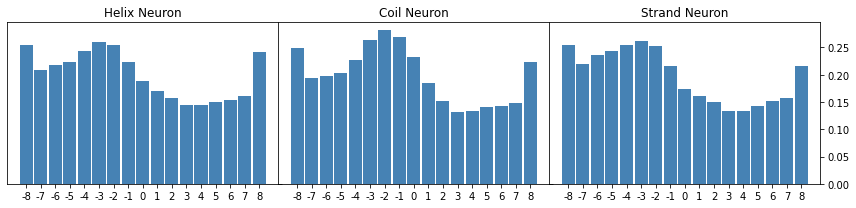

In [10]:
avg_0 = np.mean(attrib_0, axis=0)
avg_1 = np.mean(attrib_1, axis=0)
avg_2 = np.mean(attrib_2, axis=0)

LABELS = ["-"+str(x) for x in range(8,0,-1)]+[str(0)]+[str(x) for x in range(1,9,1)]

def get_sign_color(w0, pos="steelblue", neg="black"):
    return [neg if x<0 else pos for x in w0]


abs_avg_w0 = abs(avg_0)
abs_avg_w1 = abs(avg_1)
abs_avg_w2 = abs(avg_2)  #+ abs(avg_1) + abs(avg_0)

fig, axs = plt.subplots(1,3, figsize=(12,3), sharey=True)
for i,ax in enumerate(axs):
    ax.yaxis.tick_right()
    ax.set_xticks(range(len(abs_avg_w0)))
    ax.set_xticklabels(LABELS)
    if i == 2:
        ax.yaxis.set_tick_params(labelright=True, labelleft=False)
    else:
        for label in ax.get_yticklabels():
            label.set_visible(False)
axs[0].bar(range(17), abs_avg_w0, color=get_sign_color(avg_0), width=.9)
axs[1].bar(range(17), abs_avg_w1, color=get_sign_color(avg_1), width=.9)
axs[2].bar(range(17), abs_avg_w2, color=get_sign_color(avg_2), width=.9)
axs[0].set_title(f"Helix Neuron")
axs[1].set_title(f"Coil Neuron")
axs[2].set_title(f"Strand Neuron")

plt.tight_layout()
fig.subplots_adjust(hspace=0.1, wspace=0)
plt.savefig(f"plots/T5_Model.deeplift.avg.pdf", dpi=300)
plt.show()